In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

In [3]:
pip install opendatasets --upgrade

In [4]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/alsaniipe/cardatasets/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andreim08
Your Kaggle Key: ··········


100%|██████████| 1.06M/1.06M [00:00<00:00, 1.67MB/s]

In [5]:
# Definirea transformărilor pentru imaginile din setul de date
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [6]:
dataset_path = "/content/cardatasets"  # Sau calea către directorul unde ai descărcat setul de date


In [7]:
# Crearea setului de date folosind ImageFolder (asigură-te că ai o structură de directoare pentru clase)
image_dataset = ImageFolder(root=dataset_path, transform=transform)

In [8]:
# Crearea DataLoader pentru setul de date de imagini
batch_size = 16
image_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Definirea modelului Triplet
class TripletNetwork(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(TripletNetwork, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_size),
        )

    def forward(self, anchor, positive, negative):
        anchor_embedding = self.embedding(anchor)
        positive_embedding = self.embedding(positive)
        negative_embedding = self.embedding(negative)
        return anchor_embedding, positive_embedding, negative_embedding

In [10]:
# Definirea funcției de loss Triplet
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor_embedding, positive_embedding, negative_embedding):
        distance_positive = torch.norm(anchor_embedding - positive_embedding, dim=1)
        distance_negative = torch.norm(anchor_embedding - negative_embedding, dim=1)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(loss)

In [11]:
# Definirea modelului, criteriului de loss și optimizerului
embedding_size = 2
input_size = 128 * 128 * 3  # Ajustează dimensiunea în funcție de setul tău de date
model_triplet = TripletNetwork(input_size=input_size, embedding_size=embedding_size)
triplet_criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(model_triplet.parameters(), lr=0.001)

In [12]:
class TripletNetwork(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(TripletNetwork, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size, 256),  # Ajustat la 256
            nn.ReLU(),
            nn.Linear(256, embedding_size),
        )

    def forward(self, anchor, positive, negative):
        anchor_embedding = self.embedding(anchor.view(anchor.size(0), -1))
        positive_embedding = self.embedding(positive.view(positive.size(0), -1))
        negative_embedding = self.embedding(negative.view(negative.size(0), -1))
        return anchor_embedding, positive_embedding, negative_embedding



In [21]:
# Antrenarea modelului Triplet
num_epochs = 100
for epoch in range(num_epochs):
    model_triplet.train()
    total_loss = 0.0

    for batch in image_loader:
        # Extrage imaginile din batch
        images = batch[0]

        # Flatten imaginiile într-un singur tensor
        images = images.view(images.size(0), -1)

        # Împarte tensorii în funcție de dimensiune
        anchor_size = positive_size = negative_size = images.size(0) // 3

        # Asigură-te că negative_size nu depășește numărul real de exemple disponibile
        negative_size = min(negative_size, images.size(0) - (anchor_size + positive_size))

        # Redimensionează tensorul pentru a fi divizibil cu 3
        remaining = images.size(0) % 3
        if remaining != 0:
            images = images[:-remaining]

        # Generează indicii negativi
        negative_indices = torch.randint(anchor_size + positive_size, images.size(0), (negative_size,))

        # Folosește indicii pentru a extrage exemplele negative
        anchor, positive, negative = torch.split(images, [anchor_size, positive_size, negative_size])

        optimizer.zero_grad()
        anchor_embedding, positive_embedding, negative_embedding = model_triplet(anchor, positive, negative)
        loss = triplet_criterion(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(image_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")


Epoch [1/100], Average Loss: 2.3402
Epoch [2/100], Average Loss: 5.3382
Epoch [3/100], Average Loss: 4.9185
Epoch [4/100], Average Loss: 3.7119
Epoch [5/100], Average Loss: 3.5259
Epoch [6/100], Average Loss: 4.7389
Epoch [7/100], Average Loss: 3.8462
Epoch [8/100], Average Loss: 1.8902
Epoch [9/100], Average Loss: 2.6749
Epoch [10/100], Average Loss: 2.8089
Epoch [11/100], Average Loss: 2.8887
Epoch [12/100], Average Loss: 2.9113
Epoch [13/100], Average Loss: 3.3207
Epoch [14/100], Average Loss: 1.6444
Epoch [15/100], Average Loss: 2.3384
Epoch [16/100], Average Loss: 3.3469
Epoch [17/100], Average Loss: 2.7421
Epoch [18/100], Average Loss: 2.0124
Epoch [19/100], Average Loss: 2.6688
Epoch [20/100], Average Loss: 2.1103
Epoch [21/100], Average Loss: 2.5305
Epoch [22/100], Average Loss: 1.8628
Epoch [23/100], Average Loss: 2.2772
Epoch [24/100], Average Loss: 2.3247
Epoch [25/100], Average Loss: 2.0051
Epoch [26/100], Average Loss: 1.7971
Epoch [27/100], Average Loss: 2.2061
Epoch [28/

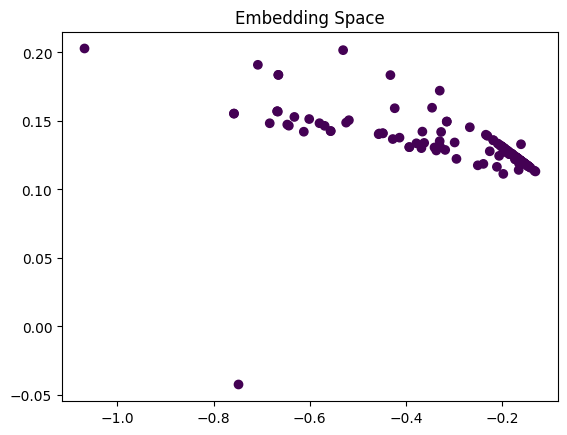

In [22]:
# Vizualizarea rezultatelor (embedding în spațiul bidimensional)
model_triplet.eval()
with torch.no_grad():
    embeddings = []

    # Parcurge setul de date și obține embedding-uri
    for i in range(len(image_dataset)):
        image, label = image_dataset[i]
        embedding = model_triplet.embedding(image.unsqueeze(0).view(1, -1)).numpy()
        embeddings.append((embedding, label))

# Afișarea rezultatelor într-un plot (trebuie ajustat în funcție de numărul de clase)
embeddings, labels = zip(*embeddings)
embeddings = np.concatenate(embeddings, axis=0)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
plt.title('Embedding Space')
plt.show()
